# Audio Recognition

In [ ]:
# Mount google drive
from google.colab import drive
drive.mount('/content/drive')
DATA_DIR = "/content/drive/MyDrive/APS 360/Data"

Mounted at /content/drive


In [ ]:
import os

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import librosa
import seaborn as sns

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader

from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.model_selection import train_test_split


In [ ]:
# Load the audio file
audio_file = os.path.join(DATA_DIR, "genres_original/blues/blues.00000.wav")
audio, sr = librosa.load(audio_file)

# Preprocess the audio
audio = librosa.util.normalize(audio)

# Extract the MFCC features
mfcc = librosa.feature.mfcc(y=audio, sr=sr, n_mfcc=20)

# Segment the features into fixed-length sequences
n_frames = 100
frame_length = mfcc.shape[1] // n_frames
segments = []
for i in range(n_frames):
    segment = mfcc[:, i*frame_length:(i+1)*frame_length]
    segments.append(segment)

# Convert the segments into numerical representations
data = np.stack(segments)
print(data.shape)

(100, 20, 12)


In [ ]:
music_data = pd.read_csv(os.path.join(DATA_DIR, 'features_3_sec.csv'))
pd.set_option('display.max_columns', None)
music_data.head()

,filename,length,chroma_stft_mean,chroma_stft_var,rms_mean,rms_var,spectral_centroid_mean,spectral_centroid_var,spectral_bandwidth_mean,spectral_bandwidth_var,rolloff_mean,rolloff_var,zero_crossing_rate_mean,zero_crossing_rate_var,harmony_mean,harmony_var,perceptr_mean,perceptr_var,tempo,mfcc1_mean,mfcc1_var,mfcc2_mean,mfcc2_var,mfcc3_mean,mfcc3_var,mfcc4_mean,mfcc4_var,mfcc5_mean,mfcc5_var,mfcc6_mean,mfcc6_var,mfcc7_mean,mfcc7_var,mfcc8_mean,mfcc8_var,mfcc9_mean,mfcc9_var,mfcc10_mean,mfcc10_var,mfcc11_mean,mfcc11_var,mfcc12_mean,mfcc12_var,mfcc13_mean,mfcc13_var,mfcc14_mean,mfcc14_var,mfcc15_mean,mfcc15_var,mfcc16_mean,mfcc16_var,mfcc17_mean,mfcc17_var,mfcc18_mean,mfcc18_var,mfcc19_mean,mfcc19_var,mfcc20_mean,mfcc20_var,label
0,blues.00000.0.wav,66149,0.335406,0.091048,0.130405,0.003521,1773.065032,167541.630869,1972.744388,117335.771563,3714.560359,1.080790e+06,0.081851,0.000558,-0.000078,0.008354,-0.000068,0.005535,129.199219,-118.627914,2440.286621,125.083626,260.956909,-23.443724,364.081726,41.321484,181.694855,-5.976108,152.963135,20.115141,75.652298,-16.045410,40.227104,17.855198,84.320282,-14.633434,83.437233,10.270527,97.001335,-9.708279,66.669891,10.183875,45.103611,-4.681614,34.169498,8.417439,48.269444,-7.233477,42.770947,-2.853603,39.687145,-3.241280,36.488243,0.722209,38.099152,-5.050335,33.618073,-0.243027,43.771767,blues
1,blues.00000.1.wav,66149,0.343065,0.086147,0.112699,0.001450,1816.693777,90525.690866,2010.051501,65671.875673,3869.682242,6.722448e+05,0.087173,0.001030,-0.000099,0.004950,-0.000103,0.004854,123.046875,-125.590706,2038.344238,122.421227,216.774185,-20.718019,231.979767,50.128387,142.700409,-11.333302,139.243118,21.385401,77.817947,-15.960796,97.364029,19.454103,57.948093,-12.465918,68.271523,17.898169,56.222176,-11.732554,54.373909,8.145000,40.662876,-7.717751,30.808521,8.397150,48.784225,-8.300493,68.584824,4.074709,64.748276,-6.055294,40.677654,0.159015,51.264091,-2.837699,97.030830,5.784063,59.943081,blues
2,blues.00000.2.wav,66149,0.346815,0.092243,0.132003,0.004620,1788.539719,111407.437613,2084.565132,75124.921716,3997.639160,7.907127e+05,0.071383,0.000425,-0.000066,0.012476,0.000065,0.004357,123.046875,-132.441940,3798.532227,115.085175,257.321289,-14.811666,192.448074,50.189293,144.166031,-0.680819,128.376892,24.650375,66.371170,-13.506104,89.319336,15.643386,55.253967,-13.216637,120.308784,10.406025,35.757862,-7.991465,47.911613,11.853963,36.569931,-4.677677,40.725075,6.571110,30.686846,-2.424750,50.313499,4.806280,67.336563,-1.768610,28.348579,2.378768,45.717648,-1.938424,53.050835,2.517375,33.105122,blues
3,blues.00000.3.wav,66149,0.363639,0.086856,0.132565,0.002448,1655.289045,111952.284517,1960.039988,82913.639269,3568.300218,9.216524e+05,0.069426,0.000304,-0.000014,0.008318,0.000018,0.005927,123.046875,-118.231087,2508.781006,132.116501,332.650574,-18.758335,109.357529,39.769306,184.693344,-13.260426,144.398224,20.468134,122.516464,-14.563448,68.937332,18.745104,74.748886,-13.755463,73.868576,12.993759,41.549564,-12.648887,58.540478,10.389314,39.102024,-4.362739,60.714748,9.156193,40.411537,-9.889441,44.666325,-1.359111,47.739452,-3.841155,28.337118,1.218588,34.770935,-3.580352,50.836224,3.630866,32.023678,blues
4,blues.00000.4.wav,66149,0.335579,0.088129,0.143289,0.001701,1630.656199,79667.267654,1948.503884,60204.020268,3469.992864,6.102111e+05,0.070095,0.000289,0.000041,0.009634,-0.000106,0.005833,123.046875,-105.968376,2118.919922,134.643646,219.562622,-19.961748,171.878754,40.171753,103.120712,-14.271939,102.651230,18.734617,79.070000,-15.619381,48.510284,19.207966,53.642956,-18.274683,95.300995,14.316693,58.821163,-5.792194,55.030254,17.045437,43.229939,-5.681399,46.515259,5.705521,24.956211,-7.986080,39.816933,2.092937,30.336359,0.664582,45.880913,1.689446,51.363583,-3.392489,26.738789,0.536961,29.146694,blues


label
blues        126.690664
classical    125.888882
country      121.095174
disco        122.734182
hiphop       125.938210
jazz         122.972381
metal        124.987786
pop          123.140297
reggae       133.978200
rock         121.434986
Name: tempo, dtype: float64


Text(0, 0.5, 'BPM')

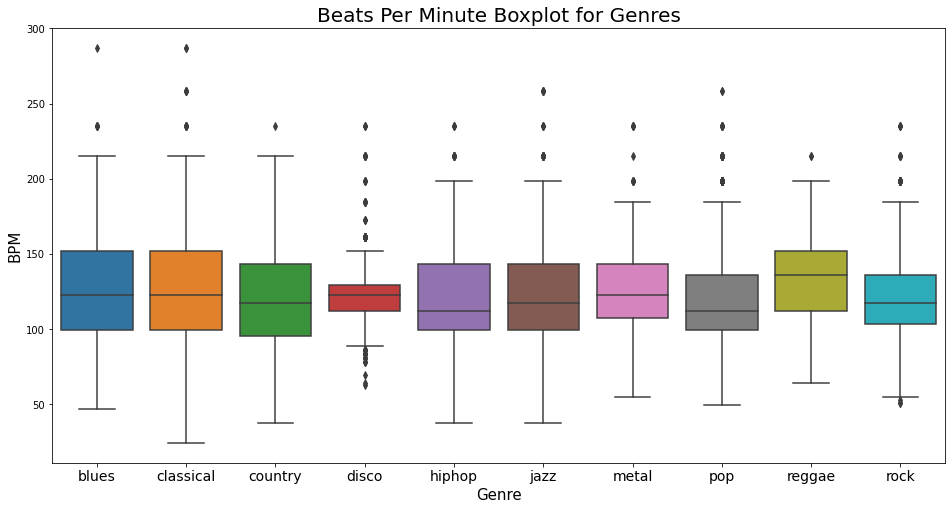

In [ ]:
# A box plot to show the distribution of music pieces in different genres in different tempo/beats per minute values.
x = music_data[["label", "tempo"]]

# Group the data by genre and calculate the mean BPM for each group
avg_bpm = music_data.groupby('label')['tempo'].mean()

# Print the average BPM for each genre
print(avg_bpm)

# store the avg_bpm as dict for gernation part
avg_bpm_dict = avg_bpm.to_dict()


fig, ax = plt.subplots(figsize=(16, 8));
sns.boxplot(x = "label", y = "tempo", data = x);

plt.title('Beats Per Minute Boxplot for Genres', fontsize = 20)
plt.xticks(fontsize = 14)
plt.yticks(fontsize = 10);
plt.xlabel("Genre", fontsize = 15)
plt.ylabel("BPM", fontsize = 15)

# Classification: ANN Training

In [ ]:
csv_file = os.path.join(DATA_DIR, "features_3_sec.csv")
df = pd.read_csv(csv_file, index_col=False)
df = df.iloc[:, 1:] # Remove filename column
df.head()

,length,chroma_stft_mean,chroma_stft_var,rms_mean,rms_var,spectral_centroid_mean,spectral_centroid_var,spectral_bandwidth_mean,spectral_bandwidth_var,rolloff_mean,rolloff_var,zero_crossing_rate_mean,zero_crossing_rate_var,harmony_mean,harmony_var,perceptr_mean,perceptr_var,tempo,mfcc1_mean,mfcc1_var,mfcc2_mean,mfcc2_var,mfcc3_mean,mfcc3_var,mfcc4_mean,mfcc4_var,mfcc5_mean,mfcc5_var,mfcc6_mean,mfcc6_var,mfcc7_mean,mfcc7_var,mfcc8_mean,mfcc8_var,mfcc9_mean,mfcc9_var,mfcc10_mean,mfcc10_var,mfcc11_mean,mfcc11_var,mfcc12_mean,mfcc12_var,mfcc13_mean,mfcc13_var,mfcc14_mean,mfcc14_var,mfcc15_mean,mfcc15_var,mfcc16_mean,mfcc16_var,mfcc17_mean,mfcc17_var,mfcc18_mean,mfcc18_var,mfcc19_mean,mfcc19_var,mfcc20_mean,mfcc20_var,label
0,66149,0.335406,0.091048,0.130405,0.003521,1773.065032,167541.630869,1972.744388,117335.771563,3714.560359,1.080790e+06,0.081851,0.000558,-0.000078,0.008354,-0.000068,0.005535,129.199219,-118.627914,2440.286621,125.083626,260.956909,-23.443724,364.081726,41.321484,181.694855,-5.976108,152.963135,20.115141,75.652298,-16.045410,40.227104,17.855198,84.320282,-14.633434,83.437233,10.270527,97.001335,-9.708279,66.669891,10.183875,45.103611,-4.681614,34.169498,8.417439,48.269444,-7.233477,42.770947,-2.853603,39.687145,-3.241280,36.488243,0.722209,38.099152,-5.050335,33.618073,-0.243027,43.771767,blues
1,66149,0.343065,0.086147,0.112699,0.001450,1816.693777,90525.690866,2010.051501,65671.875673,3869.682242,6.722448e+05,0.087173,0.001030,-0.000099,0.004950,-0.000103,0.004854,123.046875,-125.590706,2038.344238,122.421227,216.774185,-20.718019,231.979767,50.128387,142.700409,-11.333302,139.243118,21.385401,77.817947,-15.960796,97.364029,19.454103,57.948093,-12.465918,68.271523,17.898169,56.222176,-11.732554,54.373909,8.145000,40.662876,-7.717751,30.808521,8.397150,48.784225,-8.300493,68.584824,4.074709,64.748276,-6.055294,40.677654,0.159015,51.264091,-2.837699,97.030830,5.784063,59.943081,blues
2,66149,0.346815,0.092243,0.132003,0.004620,1788.539719,111407.437613,2084.565132,75124.921716,3997.639160,7.907127e+05,0.071383,0.000425,-0.000066,0.012476,0.000065,0.004357,123.046875,-132.441940,3798.532227,115.085175,257.321289,-14.811666,192.448074,50.189293,144.166031,-0.680819,128.376892,24.650375,66.371170,-13.506104,89.319336,15.643386,55.253967,-13.216637,120.308784,10.406025,35.757862,-7.991465,47.911613,11.853963,36.569931,-4.677677,40.725075,6.571110,30.686846,-2.424750,50.313499,4.806280,67.336563,-1.768610,28.348579,2.378768,45.717648,-1.938424,53.050835,2.517375,33.105122,blues
3,66149,0.363639,0.086856,0.132565,0.002448,1655.289045,111952.284517,1960.039988,82913.639269,3568.300218,9.216524e+05,0.069426,0.000304,-0.000014,0.008318,0.000018,0.005927,123.046875,-118.231087,2508.781006,132.116501,332.650574,-18.758335,109.357529,39.769306,184.693344,-13.260426,144.398224,20.468134,122.516464,-14.563448,68.937332,18.745104,74.748886,-13.755463,73.868576,12.993759,41.549564,-12.648887,58.540478,10.389314,39.102024,-4.362739,60.714748,9.156193,40.411537,-9.889441,44.666325,-1.359111,47.739452,-3.841155,28.337118,1.218588,34.770935,-3.580352,50.836224,3.630866,32.023678,blues
4,66149,0.335579,0.088129,0.143289,0.001701,1630.656199,79667.267654,1948.503884,60204.020268,3469.992864,6.102111e+05,0.070095,0.000289,0.000041,0.009634,-0.000106,0.005833,123.046875,-105.968376,2118.919922,134.643646,219.562622,-19.961748,171.878754,40.171753,103.120712,-14.271939,102.651230,18.734617,79.070000,-15.619381,48.510284,19.207966,53.642956,-18.274683,95.300995,14.316693,58.821163,-5.792194,55.030254,17.045437,43.229939,-5.681399,46.515259,5.705521,24.956211,-7.986080,39.816933,2.092937,30.336359,0.664582,45.880913,1.689446,51.363583,-3.392489,26.738789,0.536961,29.146694,blues


In [ ]:
# Create a StandardScaler object
scaler = StandardScaler()

# Normalize the first 57 columns
df.iloc[:, :58] = scaler.fit_transform(df.iloc[:, :58])

# Create a LabelEncoder object
label_encoder = LabelEncoder()

# Fit the LabelEncoder object on the string labels
df['label'] = label_encoder.fit_transform(df['label'])

In [ ]:
df.head()

,length,chroma_stft_mean,chroma_stft_var,rms_mean,rms_var,spectral_centroid_mean,spectral_centroid_var,spectral_bandwidth_mean,spectral_bandwidth_var,rolloff_mean,rolloff_var,zero_crossing_rate_mean,zero_crossing_rate_var,harmony_mean,harmony_var,perceptr_mean,perceptr_var,tempo,mfcc1_mean,mfcc1_var,mfcc2_mean,mfcc2_var,mfcc3_mean,mfcc3_var,mfcc4_mean,mfcc4_var,mfcc5_mean,mfcc5_var,mfcc6_mean,mfcc6_var,mfcc7_mean,mfcc7_var,mfcc8_mean,mfcc8_var,mfcc9_mean,mfcc9_var,mfcc10_mean,mfcc10_var,mfcc11_mean,mfcc11_var,mfcc12_mean,mfcc12_var,mfcc13_mean,mfcc13_var,mfcc14_mean,mfcc14_var,mfcc15_mean,mfcc15_var,mfcc16_mean,mfcc16_var,mfcc17_mean,mfcc17_var,mfcc18_mean,mfcc18_var,mfcc19_mean,mfcc19_var,mfcc20_mean,mfcc20_var,label
0,0.0,-0.487808,0.640520,-0.006624,0.235568,-0.566828,-0.572791,-0.493983,-0.009229,-0.518590,-0.367952,-0.454064,-0.570777,0.168385,-0.335954,0.295495,-0.009975,0.131009,0.251728,-0.141988,0.694964,-0.713185,-0.561033,-0.034151,0.229042,-0.016645,-0.292379,0.083698,0.373044,-0.423366,-0.921920,-0.889288,0.637318,0.207617,-0.754018,0.204064,0.224729,0.673577,-0.409692,0.071046,0.693864,-0.338503,0.070763,-0.642357,1.027750,-0.153788,-0.515791,-0.265968,-0.750122,-0.299108,0.168647,-0.425137,-0.003423,-0.376938,-0.499464,-0.513562,0.128414,-0.291781,0
1,0.0,-0.403142,0.131835,-0.264944,-0.342134,-0.508798,-0.749862,-0.425382,-0.519010,-0.424118,-0.642268,-0.337473,-0.440170,0.156342,-0.605355,0.263734,-0.112440,-0.055935,0.186320,-0.296811,0.618174,-0.809301,-0.447326,-0.482782,0.723712,-0.309489,-0.687218,-0.041866,0.473445,-0.394832,-0.914289,-0.017413,0.781073,-0.367204,-0.522643,-0.134981,1.087476,-0.300554,-0.668525,-0.234700,0.424272,-0.456989,-0.354962,-0.736384,1.024415,-0.140138,-0.695751,0.427020,0.457983,0.428544,-0.327031,-0.310040,-0.112125,-0.032083,-0.066593,1.011384,1.275780,0.056425,0
2,0.0,-0.361694,0.764491,0.016695,0.542195,-0.546245,-0.701852,-0.288365,-0.425734,-0.346190,-0.562723,-0.683379,-0.607419,0.175942,-0.009629,0.415753,-0.187073,-0.055935,0.121959,0.381194,0.406587,-0.721094,-0.200934,-0.617035,0.727133,-0.298483,0.097898,-0.141313,0.731507,-0.545653,-0.692909,-0.140170,0.438458,-0.425926,-0.602780,1.028363,0.240055,-0.789404,-0.190173,-0.395388,0.914693,-0.566195,0.071315,-0.458957,0.724276,-0.620000,0.295239,-0.063484,0.585548,0.503695,0.428053,-0.648762,0.316311,-0.177372,0.109337,-0.046244,0.653907,-0.521458,0
3,0.0,-0.175714,0.205477,0.024885,-0.063820,-0.723482,-0.700599,-0.517344,-0.348881,-0.607665,-0.474804,-0.726248,-0.640986,0.206475,-0.338752,0.373503,0.048886,-0.055935,0.255456,-0.115604,0.897807,-0.557221,-0.365575,-0.899218,0.141858,0.005873,-0.829252,0.005313,0.400944,0.194107,-0.788267,-0.451187,0.717328,-0.001006,-0.660298,-0.009853,0.532748,-0.651053,-0.785692,-0.131096,0.721028,-0.498634,0.115475,0.100277,1.149176,-0.362144,-0.963740,-0.215086,-0.489524,-0.065309,0.062981,-0.649076,0.092384,-0.464121,-0.211882,-0.099501,0.865880,-0.544744,0
4,0.0,-0.485895,0.337521,0.181345,-0.272072,-0.756246,-0.774827,-0.538557,-0.572962,-0.667537,-0.683920,-0.711602,-0.645175,0.238425,-0.234588,0.261354,0.034742,-0.055935,0.370652,-0.265774,0.970695,-0.803235,-0.415777,-0.686890,0.164463,-0.606729,-0.903804,-0.376751,0.263928,-0.378335,-0.883498,-0.762892,0.758943,-0.461040,-1.142710,0.469290,0.682383,-0.238469,0.091036,-0.218380,1.601141,-0.388495,-0.069426,-0.296970,0.582003,-0.771951,-0.642723,-0.345270,0.112417,-0.570609,0.856651,-0.167089,0.183265,-0.029476,-0.175130,-0.678995,0.276899,-0.606692,0


In [ ]:
# Split the dataframe into train, validation, and test sets
train_data, test_data = train_test_split(df, test_size=0.2, random_state=42)
train_data, val_data = train_test_split(train_data, test_size=0.1, random_state=42)

# Convert the dataframes to PyTorch tensors
train_X = torch.tensor(train_data.iloc[:, :-1].values, dtype=torch.float32)
train_y = torch.tensor(train_data.iloc[:, -1].values, dtype=torch.long)

val_X = torch.tensor(val_data.iloc[:, :-1].values, dtype=torch.float32)
val_y = torch.tensor(val_data.iloc[:, -1].values, dtype=torch.long)

test_X = torch.tensor(test_data.iloc[:, :-1].values, dtype=torch.float32)
test_y = torch.tensor(test_data.iloc[:, -1].values, dtype=torch.long)

# Create dataset objects
train_dataset = TensorDataset(train_X, train_y)
val_dataset = TensorDataset(val_X, val_y)
test_dataset = TensorDataset(test_X, test_y)

print(f"Train data length: {len(train_dataset)}")
print(f"Validation data length: {len(val_dataset)}")
print(f"Test data length: {len(test_dataset)}")

Train data length: 7192
Validation data length: 800
Test data length: 1998


In [ ]:
class ClassificationBase(nn.Module):
    def __init__(self):
        super(ClassificationBase, self).__init__()
        self.fc1 = nn.Linear(58, 30)
        self.fc2 = nn.Linear(30, 10)
    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x

In [ ]:
def get_accuracy(net, data_loader):
    correct = 0
    total = 0
    for (input, label) in data_loader:
        output = net(input)
        
        #select index with maximum prediction score
        output = F.softmax(output, dim=1)
        prediction = output.argmax(dim=1)
        correct += torch.eq(prediction, label).sum().item()
        total += input.shape[0]
    return correct / total

def train(model, train_dataset, val_dataset, batch_size, num_epochs, lr):
    """ Training loop. You should update this."""
    # Create data loader objects
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=True)

    criterion = nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)

    train_accuracy = np.zeros(num_epochs)
    val_accuracy = np.zeros(num_epochs)
    train_loss = np.zeros(num_epochs)
    val_loss = np.zeros(num_epochs)

    for epoch in range(num_epochs):
        total_epoch_loss = 0.0
        for (input, label) in train_loader:
            output = model(input)
            loss = criterion(output, label)
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()
            total_epoch_loss += loss.item()
        
        train_accuracy[epoch] = get_accuracy(model, train_loader)
        val_accuracy[epoch] = get_accuracy(model, val_loader)
        train_loss[epoch] = float(total_epoch_loss) / len(train_loader)

        total_epoch_loss = 0.0
        for (input, label) in val_loader:
            output = model(input)
            loss = criterion(output, label)
            total_epoch_loss += loss.item()
        
        val_loss[epoch] = float(total_epoch_loss) / len(val_loader)
        print(("Epoch {}: Train accuracy: {:.5f} | Validation accuracy: {:.5f} | Train Loss: {:.5f} | Validation Loss: {:.5f}")
            .format(
                  epoch + 1,
                  train_accuracy[epoch],
                  val_accuracy[epoch],
                  train_loss[epoch],
                  val_loss[epoch]))
    print('Finished Training')

    plt.plot(np.arange(1, num_epochs + 1), train_accuracy, label="train")
    plt.plot(np.arange(1, num_epochs + 1), val_accuracy, label="val")
    plt.title("Accuracy")
    plt.xlabel("Epochs")
    plt.ylabel("Accuracy")
    plt.legend()
    plt.show()

    plt.plot(np.arange(1, num_epochs + 1), train_loss, label="train")
    plt.plot(np.arange(1, num_epochs + 1), val_loss, label="val")
    plt.title("Loss")
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.legend()
    plt.show()

Epoch 1: Train accuracy: 0.44702 | Validation accuracy: 0.45125 | Train Loss: 1.89882 | Validation Loss: 1.55691
Epoch 2: Train accuracy: 0.55325 | Validation accuracy: 0.54750 | Train Loss: 1.39243 | Validation Loss: 1.25555
Epoch 3: Train accuracy: 0.62333 | Validation accuracy: 0.63500 | Train Loss: 1.17677 | Validation Loss: 1.08873
Epoch 4: Train accuracy: 0.65740 | Validation accuracy: 0.67250 | Train Loss: 1.05034 | Validation Loss: 1.01096
Epoch 5: Train accuracy: 0.68215 | Validation accuracy: 0.70250 | Train Loss: 0.96952 | Validation Loss: 0.93661
Epoch 6: Train accuracy: 0.70175 | Validation accuracy: 0.71000 | Train Loss: 0.90742 | Validation Loss: 0.88661
Epoch 7: Train accuracy: 0.71913 | Validation accuracy: 0.72625 | Train Loss: 0.86209 | Validation Loss: 0.83840
Epoch 8: Train accuracy: 0.73081 | Validation accuracy: 0.73875 | Train Loss: 0.82443 | Validation Loss: 0.81553
Epoch 9: Train accuracy: 0.73985 | Validation accuracy: 0.75250 | Train Loss: 0.79292 | Validati

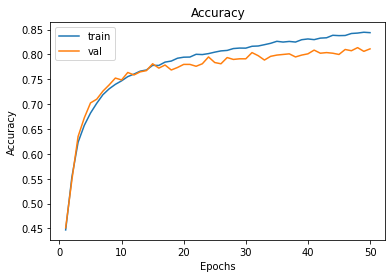

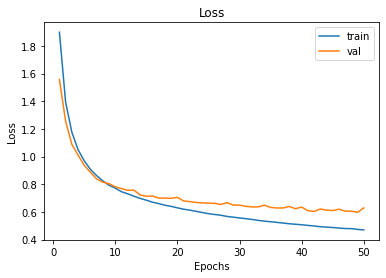

In [ ]:
TestANN = ClassificationBase()
train(TestANN, train_dataset, val_dataset, batch_size=64, num_epochs=50, lr=0.001)

In [ ]:
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=True)
test_acc = get_accuracy(TestANN, test_loader)
print("Test accuracy: ", test_acc)

Test accuracy:  0.7882882882882883


# Classification


In [ ]:
import os

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import librosa
import seaborn as sns

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader

from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.model_selection import train_test_split


In [ ]:
def extractFeaturesMeanVar(file_name): #Rafiu
  import librosa
  import librosa.display

  y, s = librosa.load(f'./{file_name}')
  audio, _ = librosa.effects.trim(y)
  har, per = librosa.effects.hpss(audio)                    
  sc = librosa.feature.spectral_centroid(audio, sr=s)[0]
  sr = librosa.feature.spectral_rolloff(audio, sr=s)[0]
  sb = librosa.feature.spectral_bandwidth(audio, sr=s)[0]
  tempo, _ = librosa.beat.beat_track(y, sr = s)             # gives global tempo
  mfcc = librosa.feature.mfcc(audio, sr=s)                  # NOTE: there are 20 different mfcc
  chroma = librosa.feature.chroma_stft(audio, sr=s)
  rms = librosa.feature.rms(audio)
  zcr = librosa.feature.zero_crossing_rate(audio)

  har_m, har_v = meanvar(har)
  per_m, per_v = meanvar(per)
  sc_m, sc_v = meanvar(sc)
  sr_m, sr_v = meanvar(sr)
  sb_m, sb_v = meanvar(sb)
  mfcc_m, mfcc_v = [0]*len(mfcc), [0]*len(mfcc)   # there are 20
  mfcc_all = []
  for i in range(len(mfcc)):
    mfcc_m[i], mfcc_v[i] = meanvar(mfcc[i]) 
    mfcc_all.append(mfcc_m[i])
    mfcc_all.append(mfcc_v[i])
  chroma_m, chroma_v = meanvar(chroma)
  rms_m, rms_v = meanvar(rms)
  zcr_m, zcr_v = meanvar(zcr)
  
  print(har.shape, per.shape, sc.shape, sr.shape, sb.shape, tempo.shape, mfcc.shape, chroma.shape, rms.shape, zcr.shape)
  
  # Same order as csv file
  features = [chroma_m, chroma_v, rms_m, rms_v, sc_m, sc_v, sb_m, sb_v, sr_m, sr_v, zcr_m, zcr_v, har_m, har_v, per_m, per_v, tempo] + mfcc_all

  return np.array(features)

def meanvar(array):
  return np.mean(array), np.var(array)


def classification(): #kevin
  pass
#use cvs data and put through ann

In [ ]:
file_name = "metal.wav"
test = extractFeaturesMeanVar(file_name)

/usr/local/lib/python3.9/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")


FileNotFoundError: ignored

In [ ]:
df1 = pd.read_csv(csv_file, index_col=False)
df1 = df1.iloc[:, 1:] # Remove filename column
df1.iloc[0,1:-1] = test
df1.iloc[:, :58] = scaler.fit_transform(df1.iloc[:, :58])
testoutput = TestANN(torch.tensor(df1.iloc[0,:58], dtype=torch.float32))
testoutput = F.softmax(testoutput, dim=-1)
testoutput = testoutput.argmax(dim=-1)
print(testoutput)

# Generation

In [ ]:
pip install MIDIUtil

In [ ]:
from midiutil import MIDIFile
import random

# generation of jazz as reference
chords = {
    'Cmaj7':  [60, 64, 67, 71], # C - E - G - B
    'Dm7':    [62, 65, 69, 72], # D - F - A - C
    'Em7':    [64, 67, 71, 74], # E - G - B - D
    'Fmaj7':  [65, 69, 72, 76], # F - A - C - E
    'G7':     [67, 71, 74, 77], # G - B - D - F
    'Am7':    [69, 72, 76, 79], # A - C - E - G
    'Bm7b5':  [71, 74, 78, 81]  # B - D - F - A (also known as B half-diminished)
}

# Define the Markov chain transition matrix for chord progression
transition_matrix = {
    'Cmaj7':  {'Dm7': 0.3, 'Em7': 0.1, 'Fmaj7': 0.2, 'G7': 0.3, 'Am7': 0.1, 'Bm7b5': 0.0},
    'Dm7':    {'Cmaj7': 0.0, 'Em7': 0.1, 'Fmaj7': 0.3, 'G7': 0.5, 'Am7': 0.1, 'Bm7b5': 0.0},
    'Em7':    {'Cmaj7': 0.1, 'Dm7': 0.1, 'Fmaj7': 0.2, 'G7': 0.4, 'Am7': 0.2, 'Bm7b5': 0.0},
    'Fmaj7':  {'Cmaj7': 0.3, 'Dm7': 0.1, 'Em7': 0.1, 'G7': 0.3, 'Am7': 0.2, 'Bm7b5': 0.0},
    'G7':     {'Cmaj7': 0.4, 'Dm7': 0.1, 'Em7': 0.1, 'Fmaj7': 0.1, 'Am7': 0.3, 'Bm7b5': 0.0},
    'Am7':    {'Cmaj7': 0.3, 'Dm7': 0.2, 'Em7': 0.1, 'Fmaj7': 0.3, 'G7': 0.1, 'Bm7b5': 0.0},
    'Bm7b5':  {'Cmaj7': 0.0, 'Dm7': 0.0, 'Em7': 0.0, 'Fmaj7': 0.0, 'G7': 0.9, 'Am7': 0.1}
}


# Function to get the next chord based on the current chord and transition matrix
def get_next_chord(current_chord, transition_matrix):
    next_chord = random.choices(
        list(transition_matrix[current_chord].keys()),
        list(transition_matrix[current_chord].values())
    )[0]
    return next_chord

# Generate a chord progression
chord_progression = ['Cmaj7']
for _ in range(20):
    current_chord = chord_progression[-1]
    next_chord = get_next_chord(current_chord, transition_matrix)
    chord_progression.append(next_chord)

# Define the BPM (e.g., 120)
bpm = avg_bpm_dict["jazz"]
ticks_per_quarternote = 120 * 2  # Set the number of ticks per quarter note

# Create a MIDI file
midi = MIDIFile(1, adjust_origin=True, ticks_per_quarternote=ticks_per_quarternote)  # Create a single-track MIDI file
midi.addProgramChange(0, 0, 0, 0)  # Set the instrument to piano
midi.addTempo(0, 0, bpm)  # Set the tempo

# Add the chord progression to the MIDI file
quarter_note_duration_ticks = ticks_per_quarternote/bpm  # Calculate the duration of a quarter note in ticks
time = 0
for chord_name in chord_progression:
    for note in chords[chord_name]:
        midi.addNote(0, 0, note, time, quarter_note_duration_ticks, 100)
    time += quarter_note_duration_ticks

# Write the MIDI file to disk
with open('chord_progression.mid', 'wb') as output_file:
    midi.writeFile(output_file)


In [ ]:
!apt-get install fluidsynth
!pip install midi2audio
!wget https://github.com/FluidSynth/fluidsynth/raw/master/sf2/VintageDreamsWaves-v2.sf2

In [ ]:
from midi2audio import FluidSynth

fs = FluidSynth('VintageDreamsWaves-v2.sf2')
fs.midi_to_audio('chord_progression.mid', 'chord_progression.wav')

In [ ]:
from IPython.display import Audio

Audio('chord_progression.wav')

In [ ]:
## code to get data set from the university of Iowa
%cd /content/gdrive/MyDrive/aps 360/music notes/
import os
from pydub import AudioSegment
import urllib.request 
for i in instrumentLink:
  link ='https://theremin.music.uiowa.edu/'+i['href']
  r=requests.get(link)
  soup1 = BeautifulSoup(r.content, 'html.parser')
  name=i['href'][17:-5]
  print(name)
  if not os.path.exists(name):
    os.mkdir(name)
  print('/content/gdrive/MyDrive/aps 360/music notes/'+name)
  for a in soup1.find_all('a'):
    if(a['href'].find('.aif')!=-1):
      b='https://theremin.music.uiowa.edu'+a['href'][2:].replace(' ','%20')
      urllib.request.urlretrieve(b,"temp.aif")
      wav_audio = AudioSegment.from_file("temp.aif")
      wav_audio.export('/content/gdrive/MyDrive/aps 360/music notes/'+name='/'+a['href'][-20:-11]+'.wav', format="wav")

# Primary Model: Classification

# Data Processing

In [2]:
import os

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
#import librosa
import seaborn as sns

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader, Dataset

from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.model_selection import train_test_split
DATA_DIR = "/"

In [2]:
# Mount google drive
from google.colab import drive
drive.mount('/content/drive')
DATA_DIR = "/content/drive/MyDrive/APS 360/Data"

Mounted at /content/drive


In [3]:
def extractFeaturesComplete(file_name):
  import librosa
  import librosa.display

  y, s = librosa.load(f'./{file_name}')
  audio, _ = librosa.effects.trim(y)
  # har, per = librosa.effects.hpss(audio)                    
  sc = librosa.feature.spectral_centroid(audio, sr=s)
  sr = librosa.feature.spectral_rolloff(audio, sr=s)
  sb = librosa.feature.spectral_bandwidth(audio, sr=s)
  tempo, _ = librosa.beat.beat_track(y, sr = s) 
  mfcc = librosa.feature.mfcc(audio, sr=s)
  chroma = librosa.feature.chroma_stft(audio, sr=s)
  rms = librosa.feature.rms(audio)
  zcr = librosa.feature.zero_crossing_rate(audio)

  # HAR and PER is not saved!

  features = [rms[0], sc[0], sb[0], sr[0], zcr[0]]

  return np.concatenate((features,chroma,mfcc), axis=0)


In [ ]:
complete = 0
for directory in os.listdir(DATA_DIR + "/genres_original"):
  for file in os.listdir(DATA_DIR + "/genres_original/" + directory):
    complete += 1
    print(complete, file)
    if (file[:-4] + ".npy") not in os.listdir(DATA_DIR + "/genres_numpy/" + directory) and file[-4:] == ".wav":
      temp = extractFeaturesComplete("/drive/MyDrive/APS 360/Data/genres_original/" + directory + "/" + file)
      np.save(DATA_DIR + "/genres_numpy/" + directory + "/" + file[:-4], temp, allow_pickle=False)


***Data Processing DONE!***

***NORMALIZE:***

In [ ]:
scaler = StandardScaler()
for directory in os.listdir(DATA_DIR + "/genres_numpy"):
  if not os.path.isdir(DATA_DIR + "/genres_normalized/" + directory):
    os.mkdir(DATA_DIR + "/genres_normalized/" + directory)
  for file in os.listdir(DATA_DIR + "/genres_numpy/" + directory):
    if file.endswith('.npy'):
      data = np.load(DATA_DIR + "/genres_numpy/" + directory + "/" + file)
      data_normalized = (data - data.mean(axis=1)[:, np.newaxis]) / data.std(axis=1)[:, np.newaxis]
      np.save(DATA_DIR + "/genres_normalized/" + directory + "/" + file[:-4],
              data_normalized, allow_pickle=False)


In [ ]:
for directory in os.listdir(DATA_DIR + "/genres_normalized"):
  for file in os.listdir(DATA_DIR + "/genres_normalized/" + directory):
    if np.load(DATA_DIR + "/genres_normalized/" + directory + "/" + file).shape[1] != 1293:
      print(np.load(DATA_DIR + "/genres_normalized/" + directory + "/" + file).shape)
      os.remove(DATA_DIR + "/genres_normalized/" + directory + "/" + file)

***Data Splitter***

In [ ]:
for directory in os.listdir(DATA_DIR + "/genres_normalized"):
  for file in os.listdir(DATA_DIR + "/genres_normalized/" + directory):
    data = np.load(DATA_DIR + "/genres_normalized/" + directory + "/" + file)
    for i in range(10):
      np.save(DATA_DIR + "/genres_normalized_split/" + directory + "/" + file[:-4] + "." + str(i),
              data[:,i*129:(i+1)*129], allow_pickle=False)
      print(file[:-4] + "." + str(i))

***Check Data***

In [ ]:
for directory in os.listdir(DATA_DIR + "/genres_normalized_split"):
  for file in os.listdir(DATA_DIR + "/genres_normalized_split/" + directory):
      print(np.load(DATA_DIR + "/genres_normalized_split/" + directory + "/" + file))

# Neural Network

In [4]:
# CHATGPT

label_dict = {'blues': 0, 'classical': 1, 'country': 2, 'disco': 3, 'hiphop': 4,
               'jazz': 5, 'metal': 6, 'pop': 7, 'reggae': 8, 'rock': 9}

class NumpyDataset(Dataset):
    def __init__(self, data_dir, label_dict):
        self.file_list = []
        self.label_list = []
        for label in os.listdir(data_dir):
            label_dir = os.path.join(data_dir, label)
            if not os.path.isdir(label_dir):
                continue
            for file_path in os.listdir(label_dir):
                if file_path.endswith('.npy'):
                      self.file_list.append(os.path.join(label_dir, file_path))
                      self.label_list.append(label_dict[label])

    def __getitem__(self, index):
        data = np.load(self.file_list[index])
        data = data.reshape(-1,data.shape[0])
        label = self.label_list[index]
        return torch.tensor(data), torch.tensor(label)

    def __len__(self):
        return len(self.file_list)

input_size = 37
hidden_size = 50

ann_input_size = hidden_size
ann_hidden_size = 40
ann_output_size = 10

class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.rnn = nn.LSTM(input_size=input_size, hidden_size=hidden_size, batch_first=True)
        self.ann = nn.Sequential(
              nn.Linear(ann_input_size*2, ann_hidden_size),
              nn.ReLU(),
              nn.Linear(ann_hidden_size, ann_output_size)
              )

    def forward(self, x):
        out, _ = self.rnn(x.float())
        out = torch.cat([torch.max(out, dim=1)[0], 
                 torch.mean(out, dim=1)], dim=1)
        out = self.ann(out)
        return out

In [19]:
def get_accuracy(model, data):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    correct = 0
    total = 0
    for sms, label in data:
      sms, label = sms, label
      output = model(sms)
      prediction = output.max(1, keepdim=True)[1]
      correct += prediction.eq(label.view_as(prediction)).sum().item()
      total += label.shape[0]
    accuracy = float(correct / total)
    return accuracy


def train(model, train_loader, batch_size, learning_rate):
  device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
  print("Using device: ", device)

  num_epochs = 30
  model = model
  loss_fn = nn.CrossEntropyLoss()
  optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
  
  train_accuracy = np.zeros(num_epochs)
  train_loss = np.zeros(num_epochs)
  
  for epoch in range(num_epochs):
      total_loss = 0
      count = 0
      for inputs, labels in train_loader:
          inputs = inputs
          labels = torch.eye(10)[labels]

          output = model(inputs)
          loss = loss_fn(output, labels)
          optimizer.zero_grad()
          loss.backward()
          optimizer.step()
          total_loss += loss
          count += 1
      
      train_loss[epoch] = float(total_loss/count)
      train_accuracy[epoch] = get_accuracy(model, train_loader)

      # model_path = get_model_name(net.name, batch_size, learning_rate, epoch)
      # torch.save(net.state_dict(), model_path)

      print("Epoch %d; Training Loss %f; Train Acc %f;" % (
              epoch+1, train_loss[epoch], train_accuracy[epoch]))

In [ ]:
batch_size=128
train_data = NumpyDataset(DATA_DIR + "/genres_normalized_split/", label_dict)
train_loader = DataLoader(train_data, batch_size=batch_size, shuffle=True)
print(len(train_loader))

TestNet = Net()
train(TestNet, train_loader, batch_size, 0.01)

In [ ]:
# Continuing Training
train_loader = DataLoader(train_data, batch_size=64, shuffle=True)
train(TestNet, train_loader, batch_size, 0.01)

In [ ]:
"""
Input shape should be 12 x 129
"""
class CNN(nn.Module):
  def __init__(self):
    super(CNN, self).__init__()

    self.conv1 = nn.Conv2d(in_channels=1, out_channels=32, kernal_size=3, padding=1)
    self.conv2 = nn.Conv2d(in_channels=32, out_channels=32, kernal_size=3, padding=1)
    self.conv3 = nn.Conv2d(in_channels=32, out_channels=1, kernal_size=1)

    self.fc1 = nn.Linear(in_features=129, out_features=64)
    self.fc2 = nn.Linear(in_features=64, out_features=10)

  def forward(self, x):
    x = F.relu(self.conv1(x))
    x = F.relu(self.conv2(x))
    x = F.relu(self.conv3(x))
    x = x.view(-1, 129)
    x = F.relu(self.fc1(x))
    x = self.fc2(x)
    return x